## **Prediksi karyawan attrition menggunakan Neural Network**

<img src="https://static.helpjuice.com/helpjuice_production/uploads/upload/image/4752/direct/1672206449992-Employee%20Attrition.jpg" alt="iris" width="700" align=center/>

*Cek Resiko dengan Sederhana*

- Salah prediksi karyawan stay - diprediksi stay, padahal resign/left
  - Resource bisa berkurang sehingga produktifitas menurun
  - Mengeluarkan cost untuk pesangon karyawan
  - Ada kemungkinan beberapa target tidak terkejar

- Salah prediksi karyawan left - diprediksi left, padahal stay
  - Sudah membuka job opening lebih dulu, HR bisa buang-buang waktu.
  - Mungkin melakukan restrukturisasi tim.

---
- Lebih besar resiko dari salah prediksi karyawan stay
- Apabila stay = negative (0) & left = positive (1)
- Maka kita ingin memperkecil nilai False Negative
- Dengan kata lain memperbesar nilai Recall

$$
\text{Recall} = \cfrac{TP}{TP + FN}
$$

In [243]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["font.size"] = 16

**Import Data**

In [126]:
def importData(filename):
    # Read Data
    data = pd.read_csv(filename)
    print(f"shape awal                    : {data.shape}, (#observasi, #fitur)")

    # Drop duplicate
    data = data.drop_duplicates()
    print(f"shape setelah drop duplikat   : {data.shape}, (#observasi, #fitur)")

    return data


In [127]:
filename = "data_hr.csv"
data = importData(filename = filename)

data.head()

shape awal                    : (14999, 10), (#observasi, #fitur)
shape setelah drop duplikat   : (11991, 10), (#observasi, #fitur)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,division,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


**Split Data Input-Ouput**

In [128]:
def splitInputOutput(data, target_column):
    X = data.drop(columns = target_column)
    y = data[target_column]

    return X, y

In [129]:
target_column = "left"
X, y = splitInputOutput(data = data,
                        target_column = target_column)

**Split Train-Test**

In [130]:
# Cek kondisi proporsi kelas target
y.value_counts(normalize = True)

# Tidak balance

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

In [131]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9592, 9), (2399, 9), (9592,), (2399,))

**Splitting Categorical & Numerical Column**

In [132]:
categorical_col = ["Work_accident", "promotion_last_5years", "division", "salary"]
numerical_col = list(set(X_train.columns) - set(categorical_col))

categorical_col, numerical_col

(['Work_accident', 'promotion_last_5years', 'division', 'salary'],
 ['last_evaluation',
  'average_montly_hours',
  'satisfaction_level',
  'time_spend_company',
  'number_project'])

In [133]:
def splitNumCat(data, num_col, cat_col):
    data_num = data[num_col]
    data_cat = data[cat_col]

    return data_num, data_cat

In [134]:
X_train_num, X_train_cat = splitNumCat(data = X_train,
                                       num_col = numerical_col,
                                       cat_col = categorical_col)

**Handling Numerical Data**

In [135]:
# Check missing value
X_train_num.isna().sum()

last_evaluation         0
average_montly_hours    0
satisfaction_level      0
time_spend_company      0
number_project          0
dtype: int64

In [136]:
# Membuat imputer untuk jaga-jaga apabila di data test ada yang kosong
from sklearn.impute import SimpleImputer

def imputerNum(data, imputer = None):
    if imputer == None:
        imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
        imputer.fit(data)

    # Transform data dengan imputer
    data_imputed = imputer.transform(data)
    data_imputed = pd.DataFrame(data_imputed,
                                index = data.index,
                                columns = data.columns)
    
    return data_imputed, imputer

In [137]:
X_train_num_imputed, imputer_num = imputerNum(data = X_train_num)

In [138]:
X_train_num_imputed.head()

,last_evaluation,average_montly_hours,satisfaction_level,time_spend_company,number_project
9492,0.56,123.0,0.44,3.0,3.0
11555,0.44,154.0,0.98,6.0,4.0
11301,0.99,133.0,0.76,4.0,3.0
5578,0.55,156.0,0.47,2.0,2.0
6241,0.68,151.0,0.84,2.0,4.0


**Handling Categorical Data**

In [139]:
# Check missing value
X_train_cat.isna().sum()

Work_accident            0
promotion_last_5years    0
division                 0
salary                   0
dtype: int64

In [140]:
# Membuat imputer untuk jaga-jaga apabila di data test ada yang kosong
def imputerCat(data, imputer = None):
    if imputer == None:
        # Buat imputer
        imputer = SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = "UNKNOWN")
        imputer.fit(data)

    # Transform data dengan imputer
    data_imputed = imputer.transform(data)
    data_imputed = pd.DataFrame(data_imputed,
                                index = data.index,
                                columns = data.columns)
    
    return data_imputed, imputer

In [141]:
X_train_cat_imputed, imputer_cat = imputerCat(data = X_train_cat)

In [142]:
X_train_cat_imputed.head()

,Work_accident,promotion_last_5years,division,salary
9492,0,0,accounting,medium
11555,1,0,sales,medium
11301,0,0,sales,low
5578,0,0,management,medium
6241,0,0,technical,low


**One Hot Encoding Data**

In [143]:
from sklearn.preprocessing import OneHotEncoder

def encoderCat(data, encoder_col = None, encoder = None):
    if encoder == None:
        encoder = OneHotEncoder(handle_unknown = "ignore", drop = "if_binary")
        encoder.fit(data)
        encoder_col = encoder.get_feature_names_out(data.columns)

    # Transform data
    data_encoded = encoder.transform(data).toarray()
    data_encoded = pd.DataFrame(data_encoded,
                                index = data.index,
                                columns = encoder_col)
    
    return data_encoded, encoder_col, encoder

In [144]:
X_train_cat_encoded, encoder_col, encoder_OHE = encoderCat(data = X_train_cat_imputed)

In [145]:
X_train_cat_imputed.head().T

,9492,11555,11301,5578,6241
Work_accident,0,1,0,0,0
promotion_last_5years,0,0,0,0,0
division,accounting,sales,sales,management,technical
salary,medium,medium,low,medium,low


In [146]:
X_train_cat_encoded.head().T

,9492,11555,11301,5578,6241
Work_accident_1,0.0,1.0,0.0,0.0,0.0
promotion_last_5years_1,0.0,0.0,0.0,0.0,0.0
division_IT,0.0,0.0,0.0,0.0,0.0
division_RandD,0.0,0.0,0.0,0.0,0.0
division_accounting,1.0,0.0,0.0,0.0,0.0
division_hr,0.0,0.0,0.0,0.0,0.0
division_management,0.0,0.0,0.0,1.0,0.0
division_marketing,0.0,0.0,0.0,0.0,0.0
division_product_mng,0.0,0.0,0.0,0.0,0.0
division_sales,0.0,1.0,1.0,0.0,0.0


In [147]:
encoder_col

array(['Work_accident_1', 'promotion_last_5years_1', 'division_IT',
       'division_RandD', 'division_accounting', 'division_hr',
       'division_management', 'division_marketing',
       'division_product_mng', 'division_sales', 'division_support',
       'division_technical', 'salary_high', 'salary_low', 'salary_medium'],
      dtype=object)

**Concat Data**

In [148]:
X_train_concat = pd.concat([X_train_num_imputed, X_train_cat_encoded], axis = 1)
X_train_concat.head()

,last_evaluation,average_montly_hours,satisfaction_level,time_spend_company,number_project,Work_accident_1,promotion_last_5years_1,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
9492,0.56,123.0,0.44,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11555,0.44,154.0,0.98,6.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11301,0.99,133.0,0.76,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5578,0.55,156.0,0.47,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6241,0.68,151.0,0.84,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


**Balancing Data: SMOTE**

In [149]:
# Cek missing values
X_train_concat.isna().sum()

last_evaluation            0
average_montly_hours       0
satisfaction_level         0
time_spend_company         0
number_project             0
Work_accident_1            0
promotion_last_5years_1    0
division_IT                0
division_RandD             0
division_accounting        0
division_hr                0
division_management        0
division_marketing         0
division_product_mng       0
division_sales             0
division_support           0
division_technical         0
salary_high                0
salary_low                 0
salary_medium              0
dtype: int64

In [150]:
y_train.value_counts()

left
0    7999
1    1593
Name: count, dtype: int64

In [152]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(sampling_strategy = "minority", random_state = 123)

X_train_smote, y_train = smt.fit_resample(X_train_concat, y_train)

In [153]:
y_train.value_counts()

left
0    7999
1    7999
Name: count, dtype: int64

**Scale Data**

In [158]:
from sklearn.preprocessing import StandardScaler

In [159]:
def standardizeData(data, scaler = None):
    if scaler == None:
        scaler = StandardScaler()
        scaler.fit(data)

    # Tranform data
    data_scaled = scaler.transform(data)
    data_scaled = pd.DataFrame(data_scaled,
                               index = data.index,
                               columns = data.columns)
    
    return data_scaled, scaler


In [160]:
X_train_clean, scaler = standardizeData(data = X_train_smote)
X_train_clean.head()

,last_evaluation,average_montly_hours,satisfaction_level,time_spend_company,number_project,Work_accident_1,promotion_last_5years_1,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
0,-0.890707,-1.486431,-0.431432,-0.471144,-0.578244,-0.351352,-0.110301,-0.297787,-0.235745,4.611810,-0.249135,-0.185267,-0.256809,-0.255502,-0.658414,-0.441795,-0.502607,-0.244195,-1.078011,1.203697
1,-1.560967,-0.914857,1.603578,2.009526,0.111046,2.972531,-0.110301,-0.297787,-0.235745,-0.241631,-0.249135,-0.185267,-0.256809,-0.255502,1.620610,-0.441795,-0.502607,-0.244195,-1.078011,1.203697
2,1.511055,-1.302053,0.774500,0.355746,-0.578244,-0.351352,-0.110301,-0.297787,-0.235745,-0.241631,-0.249135,-0.185267,-0.256809,-0.255502,1.620610,-0.441795,-0.502607,-0.244195,0.954351,-0.853490
3,-0.946562,-0.877982,-0.318376,-1.298034,-1.267535,-0.351352,-0.110301,-0.297787,-0.235745,-0.241631,-0.249135,5.984305,-0.256809,-0.255502,-0.658414,-0.441795,-0.502607,-0.244195,-1.078011,1.203697
4,-0.220448,-0.970171,1.075983,-1.298034,0.111046,-0.351352,-0.110301,-0.297787,-0.235745,-0.241631,-0.249135,-0.185267,-0.256809,-0.255502,-0.658414,-0.441795,2.137941,-0.244195,0.954351,-0.853490


**Transform Test Data**

In [161]:
def transformTestData(data, num_col, cat_col, encoder_col,
                      imputer_num, imputer_cat, encoder_cat,
                      scaler):
    # 1. Split num-cat
    data_num, data_cat = splitNumCat(data = data,
                                     num_col = num_col,
                                     cat_col = cat_col)
    
    # 2. Handling num
    data_num_imputed, _ = imputerNum(data = data_num,
                                     imputer = imputer_num)
    
    # 3. Handling cat
    data_cat_imputed, _ = imputerCat(data = data_cat,
                                     imputer = imputer_cat)
    data_cat_encoded, _, _ = encoderCat(data = data_cat_imputed,
                                        encoder_col = encoder_col,
                                        encoder = encoder_cat)
    
    # 4. Concat data
    data_concat = pd.concat([data_num_imputed, data_cat_encoded],
                            axis = 1)
    
    # 5. Scale data
    data_clean, _ = standardizeData(data = data_concat,
                                    scaler = scaler)
    
    return data_clean

In [162]:
X_test_clean = transformTestData(data = X_test,
                                 num_col = numerical_col, 
                                 cat_col = categorical_col,
                                 encoder_col = encoder_col,
                                 imputer_num = imputer_num,
                                 imputer_cat = imputer_cat,
                                 encoder_cat = encoder_OHE,
                                 scaler = scaler)

X_test_clean.head()

,last_evaluation,average_montly_hours,satisfaction_level,time_spend_company,number_project,Work_accident_1,promotion_last_5years_1,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
8578,1.287635,-0.232656,1.000612,2.009526,1.489626,-0.351352,-0.110301,-0.297787,-0.235745,4.611810,-0.249135,-0.185267,-0.256809,-0.255502,-0.658414,-0.441795,-0.502607,-0.244195,-1.078011,1.203697
5756,0.784941,1.168622,-1.411252,0.355746,0.800336,-0.351352,-0.110301,-0.297787,-0.235745,4.611810,-0.249135,-0.185267,-0.256809,-0.255502,-0.658414,-0.441795,-0.502607,-0.244195,-1.078011,1.203697
3994,1.455200,-0.804230,0.284590,-1.298034,0.111046,-0.351352,-0.110301,-0.297787,-0.235745,-0.241631,-0.249135,-0.185267,-0.256809,-0.255502,1.620610,-0.441795,-0.502607,-0.244195,-1.078011,1.203697
1784,-1.169982,-1.007047,-0.469118,-0.471144,-1.267535,2.972531,-0.110301,-0.297787,-0.235745,4.611810,-0.249135,-0.185267,-0.256809,-0.255502,-0.658414,-0.441795,-0.502607,-0.244195,-1.078011,1.203697
10508,1.455200,0.762989,-0.167635,-0.471144,0.111046,-0.351352,-0.110301,-0.297787,-0.235745,-0.241631,-0.249135,-0.185267,-0.256809,-0.255502,-0.658414,2.443182,-0.502607,-0.244195,-1.078011,1.203697


In [163]:
X_test_clean.columns

Index(['last_evaluation', 'average_montly_hours', 'satisfaction_level',
       'time_spend_company', 'number_project', 'Work_accident_1',
       'promotion_last_5years_1', 'division_IT', 'division_RandD',
       'division_accounting', 'division_hr', 'division_management',
       'division_marketing', 'division_product_mng', 'division_sales',
       'division_support', 'division_technical', 'salary_high', 'salary_low',
       'salary_medium'],
      dtype='object')

In [164]:
X_train_clean.columns

Index(['last_evaluation', 'average_montly_hours', 'satisfaction_level',
       'time_spend_company', 'number_project', 'Work_accident_1',
       'promotion_last_5years_1', 'division_IT', 'division_RandD',
       'division_accounting', 'division_hr', 'division_management',
       'division_marketing', 'division_product_mng', 'division_sales',
       'division_support', 'division_technical', 'salary_high', 'salary_low',
       'salary_medium'],
      dtype='object')

In [165]:
len(X_train_clean.columns)

20

---
# Multi-Layer Perceptron (Neural Network)

- Mengadaptasi cara sel otak transfer & mengolah informasi.
- Satuan terkecilnya adalah Neuron (Perceptron)
- 1 Perceptron dapat menerima beberapa input
- 1 Perceptron mengeluarkan 1 output
- Input-input akan dijumlahkan secara berbobot dahulu (`preActivation`)
- Kemudian akan diaktifasi menggunakan `activation function` seperti Sigmoid, ReLU, TanH, dan sebagainya.

---
## Feed Propagation
- Misal ingin selesaikan kasus klasifikasi
- Kita buat arsitektur Neural Network dengan 1 perceptron

In [166]:
def preActivation(X, w):
    """
    Fungsi untuk mendapatkan nilai pre activation (weighted-sum)
    :param X: <pandas DataFrame> data input
    :param w: <numpy array> weight dari masing-masing input
    :return a: <numpy array> weighted sum atau pre activation
    """
    a = np.dot(X, w[1:]) + w[0]
    return a

In [167]:
def activationFunction(a, types):
    """
    Fungsi untuk melakukan aktifasi nilai pre activation
    :param a: <numpy array> pre activation value
    :param types: <str> pilihan fungsi aktivasi
    :return y: <numpy array> output perceptron
    """
    if types == "linear":
        y = a
    elif types == "sigmoid":
        y = 1 / (1 + np.exp(-a))
    elif types == "relu":
        y = np.max(0, a)
    else:
        raise Exception("Activation Function tidak terdaftar")
    return y

**Melakukan Forward Propagation**

In [169]:
# Buat random weight
# Ada 20 weight & 1 bias
w = np.random.rand(21)
w

array([0.32469433, 0.08455558, 0.30998589, 0.66215808, 0.7052233 ,
       0.17570068, 0.97878812, 0.9677175 , 0.06104378, 0.13944973,
       0.34884557, 0.59193509, 0.0370141 , 0.971474  , 0.40498086,
       0.82975981, 0.72939084, 0.97440989, 0.64756563, 0.1865263 ,
       0.68402012])

Pada data train

In [170]:
# Cari pre-activation function
a = preActivation(X = X_train_clean,
                  w = w)

In [171]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_train = activationFunction(a = a,
                                        types = "sigmoid")

In [172]:
# Buat prediksi
thresh = 0.5
y_pred_train = (y_pred_proba_train > thresh).astype("int")

Pada data test

In [173]:
# Cari pre-activation function
a = preActivation(X = X_test_clean,
                  w = w)

In [174]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_test = activationFunction(a = a,
                                       types = "sigmoid")

In [175]:
# Buat prediksi
y_pred_test = (y_pred_proba_test > thresh).astype("int")

Mengecek performa

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Pada data train

In [176]:
# Menampilkan confusion matrix
confusion_matrix(y_true = y_train,
                 y_pred = y_pred_train)

array([[3453, 4546],
       [4549, 3450]], dtype=int64)

In [178]:
# Menampilkan accuracy score
accuracy_score(y_true = y_train,
               y_pred = y_pred_train)

0.4314914364295537

In [180]:
# Menampilkan score
print(classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.43      0.43      0.43      7999
    left (1)       0.43      0.43      0.43      7999

    accuracy                           0.43     15998
   macro avg       0.43      0.43      0.43     15998
weighted avg       0.43      0.43      0.43     15998



**Baseline**
- karena data sudah balance, accuracy baseline adalah 50%
- model ini lebih buruk dibanding baseline, jadi harus diimprove

**Focus**
- `weighted_avg recall` bernilai 0.43, artinya dari yang **benar-benar** left, hanya 43% yang berhasil diprediksi left.
- Berarti masih ada hampir 57% karyawan yang left tapi salah prediksi, dengan kata lain resikonya besar.
- Kita ingin kecilkan hal tersebut

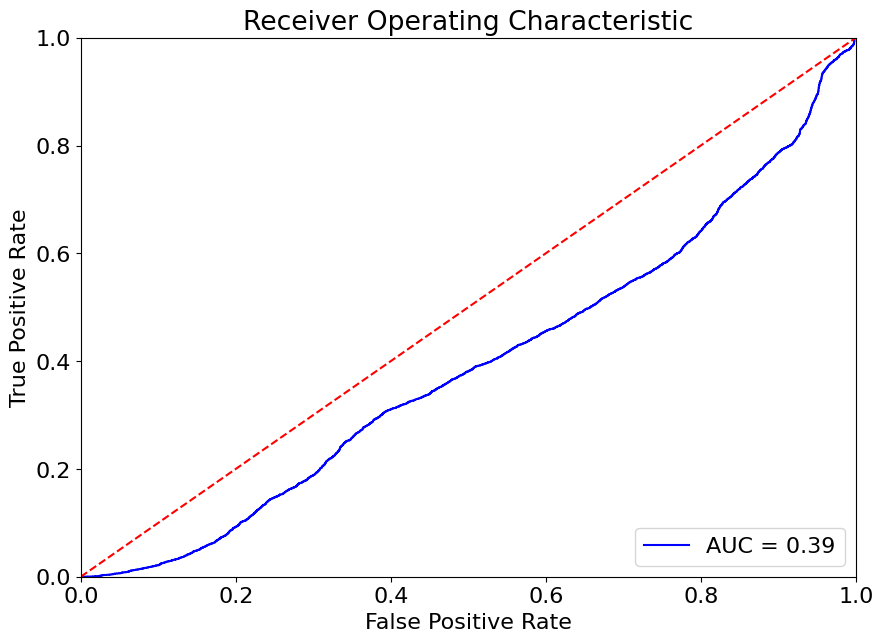

In [181]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_train, y_pred_proba_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Pada data test

In [182]:
# Menampilkan confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = y_pred_test)

array([[ 846, 1155],
       [ 237,  161]], dtype=int64)

In [183]:
# Menampilkan accuracy score
accuracy_score(y_true = y_test,
               y_pred = y_pred_test)

0.41975823259691536

In [184]:
# Menampilkan score
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.78      0.42      0.55      2001
    left (1)       0.12      0.40      0.19       398

    accuracy                           0.42      2399
   macro avg       0.45      0.41      0.37      2399
weighted avg       0.67      0.42      0.49      2399



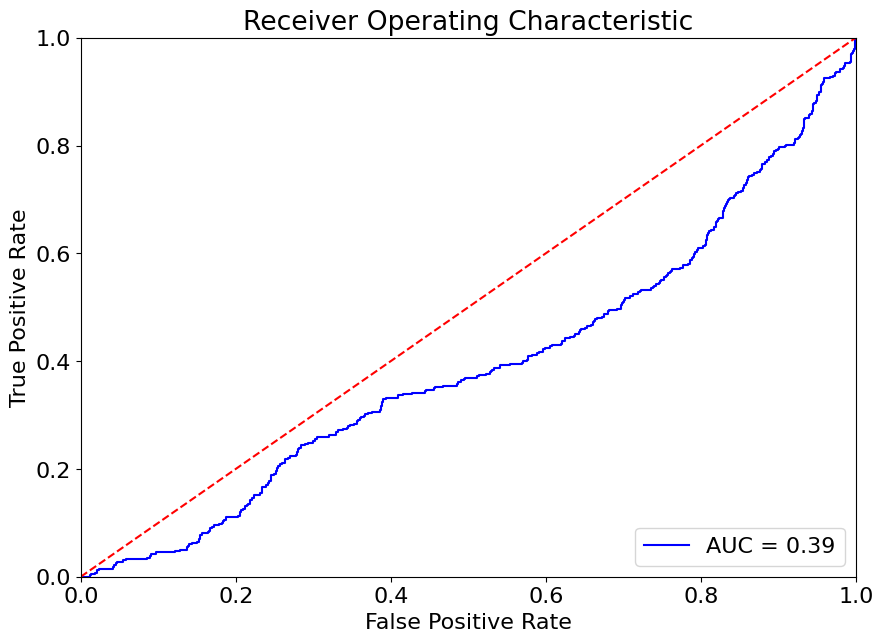

In [185]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test,
                                         y_pred_proba_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Masih jelek, ingin kita improve

# Gradient Descent

- Akurasi model random masih kecil, ingin kita tingkatkan
- Artinya, **weight** ingin kita optimasi
- Dapat dioptimasi menggunakan **Gradient Descent**

<center>
<img src="https://static.javatpoint.com/tutorial/machine-learning/images/gradient-descent-in-machine-learning1.png">
<br>
<a href="https://www.javatpoint.com/gradient-descent-in-machine-learning">source</a>
</center>

Algoritma:
- Inisialisasi weight, *bisa random*
- Cari gradient error terhadap weight
- Lakukan update weight dari informasi gradient tersebut

$$
w_{\text{new}} = w_{\text{old}} - \nabla_{w} E
$$

- Ulangi hingga stopping criteria tercapai (max. iteration atau weight tidak berubah --> $\nabla_{w} E = 0$)

---
## Backpropagation & Gradient Descent

$$
\begin{align*}
a^{(i)} &= w_{0} + w_{1}x_{1}^{(i)} + w_{2}x_{2}^{(i)} + \cdots + w_{20}x_{20}^{(i)} \\
\hat{y}^{(i)} &= \sigma (a^{(i)}) = \cfrac{1}{1 + \exp(-a^{(i)})}\\ 
\text{error}^{(i)} &= (y^{(i)} - \hat{y}^{(i)})^{2}
\end{align*}
$$

Cari gradient error menggunakan chain rules

$$
\begin{align*}
\cfrac{\partial \text{error}}{\partial w_{0}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{0}} \\ \\
\cfrac{\partial \text{error}}{\partial w_{1}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{1}} \\ \\
\cfrac{\partial \text{error}}{\partial w_{2}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{2}} \\ \\
\vdots \\ \\ 
\cfrac{\partial \text{error}}{\partial w_{20}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{20}}
\end{align*}
$$

Maka didapat

$$
\begin{align*}
\cfrac{\partial \text{error}}{\partial \hat{y}} &= -2 (y - \hat{y}) \\ \\
\cfrac{\partial \hat{y}}{\partial a} &= \sigma(a)(1 - \sigma(a)) \\ \\
\cfrac{\partial a}{\partial w_{0}} &= 1 \\ \\
\cfrac{\partial a}{\partial w_{1}} &= x_{1} \\ \\
\cfrac{\partial a}{\partial w_{2}} &= x_{2} \\ \\
\vdots \\ \\
\cfrac{\partial a}{\partial w_{20}} &= x_{20}
\end{align*}
$$

In [186]:
def gradientDescent(X, y, 
                    learning_rate, max_iter, 
                    epsilon = 1e-6):
    """
    Fungsi untuk melakukan update weight
    """
    X = np.array(X)
    n = X.shape[0]          # banyak data
    p = X.shape[1] + 1      # banyak parameter

    # Inisialisasi weights
    w = np.ones(p)

    # Inisialisasi
    w_hist = []
    loss_hist = []
    iter = 0
    previous_loss = 0

    # Melakukan iterasi
    for iter in range(max_iter):
        # Buat prediksi
        a = preActivation(X = X, w = w)
        y_pred = activationFunction(a = a, types = "sigmoid")

        # Cari error
        current_loss = np.linalg.norm(y - y_pred)**2
        
        if np.abs(previous_loss - current_loss) < epsilon:
            break

        # Update
        previous_loss = current_loss
        loss_hist.append(current_loss)
        w_hist.append(w)
        
        # Cari gradient error
        derr_dy = -2 * (y - y_pred)
        dy_da = y_pred * (1 - y_pred)
        
        derr_dw = np.zeros(p)
        for j in range(p):
            # Cari da_dw_j
            if j == 0:
                da_dw = np.ones(n)
            else:
                da_dw = X[:, j-1]
            
            # Cari error
            derr_dw[j] = np.sum(derr_dy * dy_da * da_dw)


        # Update weight dari gradient error
        for j in range(p):
            w[j] = w[j] - learning_rate * derr_dw[j]

        if iter%100 == 0:
            print(f"iterasi {iter+1} - Loss: {current_loss:.4f}")

    # Print last iteration
    print(f"iterasi {iter+1} - Loss: {current_loss:.4f}")

    return loss_hist, w_hist

In [191]:
loss_hist, w_hist = gradientDescent(X = X_train_clean,
                                    y = y_train,
                                    learning_rate = 0.01,
                                    max_iter = 5000)

iterasi 1 - Loss: 7488.2842
iterasi 101 - Loss: 2026.2927
iterasi 201 - Loss: 2004.3616
iterasi 301 - Loss: 1991.9309
iterasi 401 - Loss: 1991.4491
iterasi 501 - Loss: 1990.2176
iterasi 601 - Loss: 1989.3384
iterasi 701 - Loss: 1988.7000
iterasi 801 - Loss: 1988.2322
iterasi 901 - Loss: 1987.8837
iterasi 1001 - Loss: 1987.6205
iterasi 1101 - Loss: 1987.4200
iterasi 1201 - Loss: 1987.2661
iterasi 1301 - Loss: 1987.1474
iterasi 1401 - Loss: 1987.0553
iterasi 1501 - Loss: 1986.9837
iterasi 1601 - Loss: 1986.9279
iterasi 1701 - Loss: 1986.8843
iterasi 1801 - Loss: 1986.8502
iterasi 1901 - Loss: 1986.8234
iterasi 2001 - Loss: 1986.8025
iterasi 2101 - Loss: 1986.7861
iterasi 2201 - Loss: 1986.7732
iterasi 2301 - Loss: 1986.7630
iterasi 2401 - Loss: 1986.7551
iterasi 2501 - Loss: 1986.7488
iterasi 2601 - Loss: 1986.7439
iterasi 2701 - Loss: 1986.7400
iterasi 2801 - Loss: 1986.7370
iterasi 2901 - Loss: 1986.7346
iterasi 3001 - Loss: 1986.7327
iterasi 3101 - Loss: 1986.7312
iterasi 3201 - Loss:

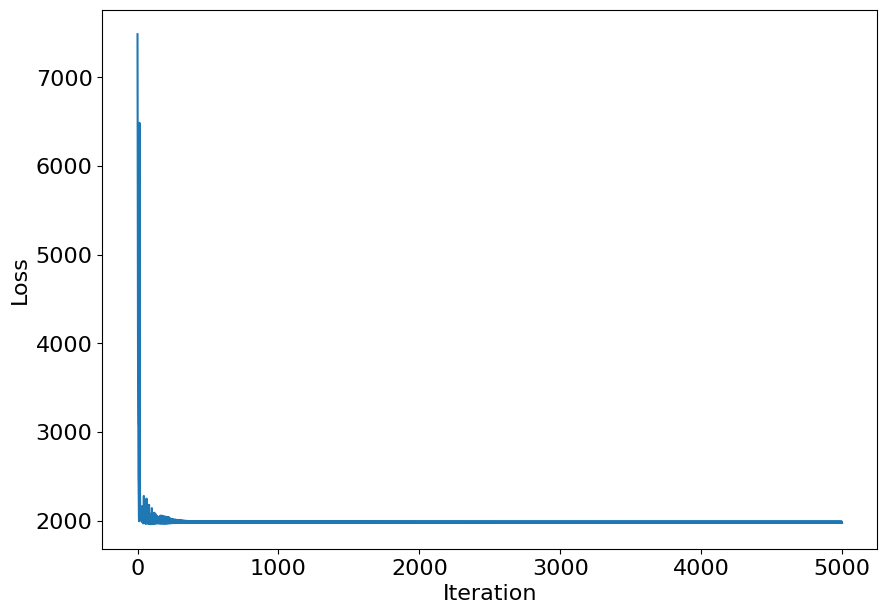

In [192]:
# Plot Error history
plt.plot([i for i in range(len(loss_hist))], loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [193]:
# Cari best weights
w_best = w_hist[-1]
w_best

array([ -2.29679825,   0.45739004,  -0.41015165, -10.64945458,
        18.18397882,  -7.46030211,  -0.68593812,  -3.72184707,
         0.8270081 ,   0.52704241,   0.58660481,   0.81840853,
         0.46569407,   0.84444105,   0.89481927,   1.62080934,
         0.99365563,   1.36336113,   0.20165087,   1.26259706,
         1.10205236])

Pada data train

In [194]:
# Cari pre-activation function
a = preActivation(X = X_train_clean,
                  w = w_best)

In [195]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_train = activationFunction(a = a,
                                        types = "sigmoid")

In [196]:
# Buat prediksi
thresh = 0.5

y_pred_train = (y_pred_proba_train > thresh).astype("int")

Pada data test

In [197]:
# Cari pre-activation function
a = preActivation(X = X_test_clean,
                  w = w_best)

In [198]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_test = activationFunction(a = a,
                                       types = "sigmoid")

In [199]:
# Buat prediksi
y_pred_test = (y_pred_proba_test > thresh).astype("int")

Cek performa

1. Pada data train

In [200]:
# Menampilkan confusion matrix
confusion_matrix(y_true = y_train,
                 y_pred = y_pred_train)

array([[6277, 1722],
       [ 356, 7643]], dtype=int64)

In [201]:
# Menampilkan score
accuracy_score(y_true = y_train,
               y_pred = y_pred_train)

0.8701087635954494

In [202]:
# Menampilkan score
print(classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.95      0.78      0.86      7999
    left (1)       0.82      0.96      0.88      7999

    accuracy                           0.87     15998
   macro avg       0.88      0.87      0.87     15998
weighted avg       0.88      0.87      0.87     15998



- Ada perbaikan recall, tadinya 49% sekarang jadi 87%
- Membaik

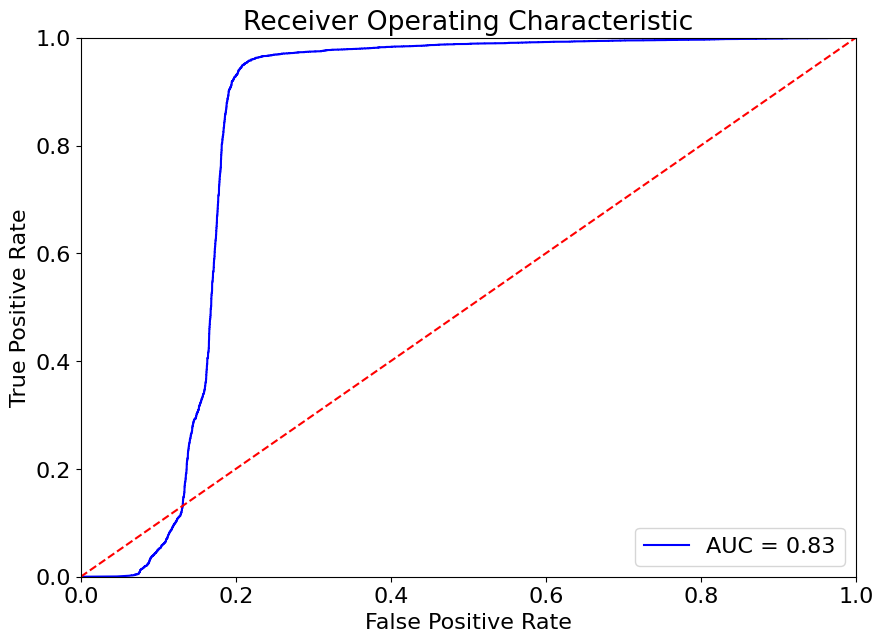

In [203]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_train,
                                         y_pred_proba_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

2. Pada data test

In [204]:
# Menampilkan confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = y_pred_test)

array([[1538,  463],
       [  27,  371]], dtype=int64)

In [205]:
# Menampilkan score
accuracy_score(y_true = y_test,
               y_pred = y_pred_test)

0.7957482284285119

In [206]:
# Menampilkan score
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.98      0.77      0.86      2001
    left (1)       0.44      0.93      0.60       398

    accuracy                           0.80      2399
   macro avg       0.71      0.85      0.73      2399
weighted avg       0.89      0.80      0.82      2399



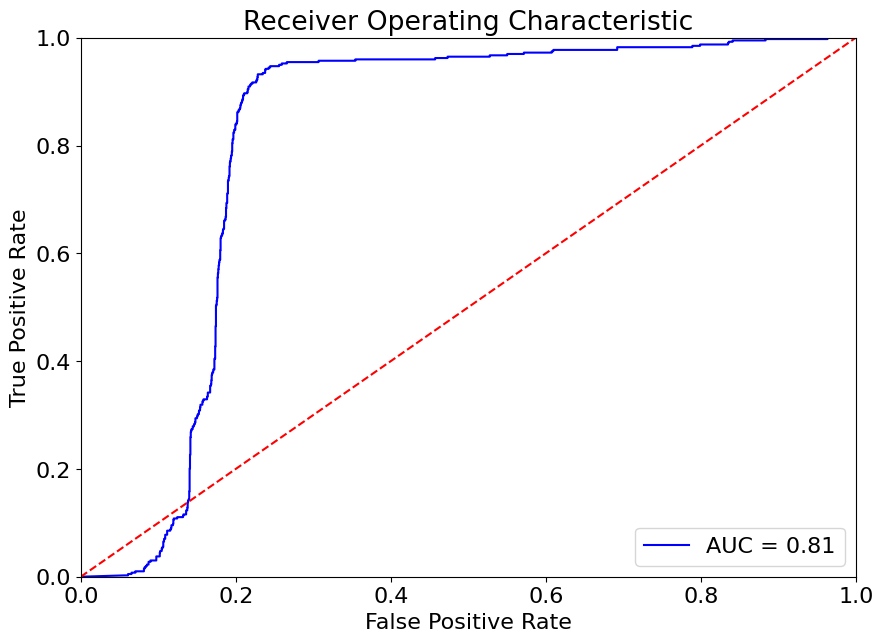

In [207]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test,
                                         y_pred_proba_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---
## Membuat Model Neural Network

In [ ]:
pip install tensorflow

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/276.5 MB ? eta -:--:--
   ---------------------------------------- 0.2/276.5 MB 3.5 MB/s eta 0:01:20
   ---------------------------------------- 0.3/276.5 MB 2.8 MB/s eta 0:01:39
   ---------------------------------------- 0.4/276.5 MB 2.4 MB/s eta 0:01:56
   ---------------------------------------- 0.6/276.5 MB 2.5 MB/s eta 0:01:50
   ---------------------------------------- 0.8/276.5 MB 2.8 MB/s eta 0:01:40
   ---------------------------------------- 1.0/276.5 MB 2.8 MB/s eta 0:01:40
   ---------------------------------------- 1.1/276.5 MB 3.0 MB/s eta 0:01:33
   ---------------------------------------- 1.3/276.5 MB 2.9 MB/s eta 0:01:35
   ---------------------------------------- 1.4/276.5 MB 2.9 MB/s eta 0:01:35
   ---------------------------------------- 1.4/276.5 MB 2.9 MB/s eta 0:01:35
  

  You can safely remove it manually.

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [208]:
# Import library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

**Arsitektur Simpel**

In [209]:
# Membuat arsitektur model dengan 1 perceptron
model = Sequential([
    Dense(1, input_shape = (X_train_clean.shape[1],), activation = "sigmoid")
])

# Membuat optimizer, menggunakan ADAM (varian gradient descent)
opt = SGD(learning_rate = 0.01)

# Compile model
model.compile(loss = "binary_crossentropy",
              optimizer = opt,
              metrics = ["accuracy"])

In [210]:
# Train model
model_hist = model.fit(X_train_clean, y_train,
                       epochs = 10,
                       verbose = 1)

Epoch 1/10
500/500 [==============================] - 2s 2ms/step - loss: 0.7024 - accuracy: 0.6221
Epoch 2/10
500/500 [==============================] - 1s 2ms/step - loss: 0.5302 - accuracy: 0.8018
Epoch 3/10
500/500 [==============================] - 1s 2ms/step - loss: 0.5050 - accuracy: 0.8120
Epoch 4/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4970 - accuracy: 0.8105
Epoch 5/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4932 - accuracy: 0.8145
Epoch 6/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4911 - accuracy: 0.8124
Epoch 7/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4898 - accuracy: 0.8134
Epoch 8/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4890 - accuracy: 0.8134
Epoch 9/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4885 - accuracy: 0.8122
Epoch 10/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4882 - accuracy: 0.8128

In [211]:
# Summary Model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


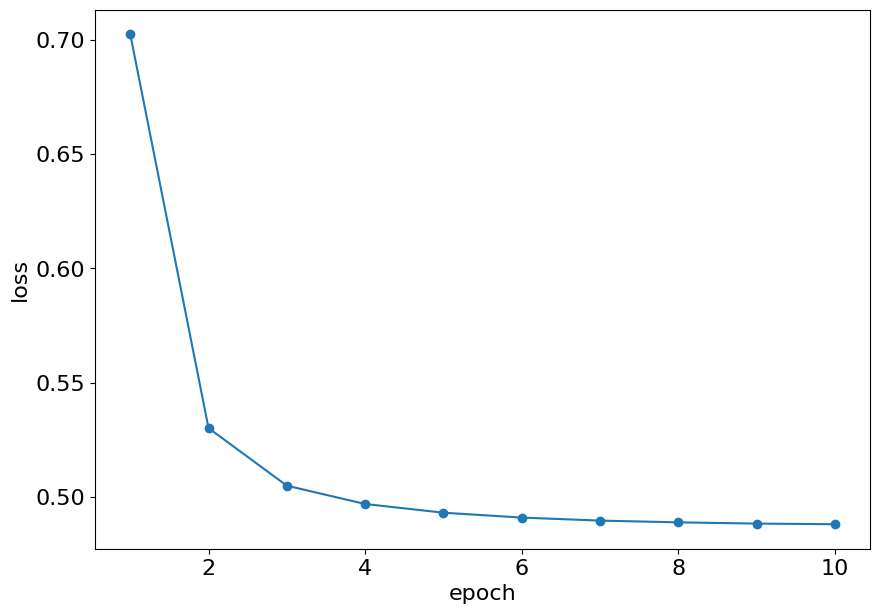

In [212]:
# Plot Error
plt.plot(1 + np.arange(10), model_hist.history["loss"], marker="o")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Pada data train

In [213]:
# Prediksi
y_pred_proba_train = model.predict(X_train_clean)
y_pred_proba_train

500/500 [==============================] - 1s 2ms/step


array([[0.446313  ],
       [0.07561374],
       [0.58653843],
       ...,
       [0.69963473],
       [0.42492238],
       [0.4583874 ]], dtype=float32)

In [214]:
# Buat prediksi
thresh = 0.5

y_pred_train = (y_pred_proba_train > thresh).astype("int")

Pada data test

In [215]:
# Prediksi
y_pred_proba_test = model.predict(X_test_clean)
y_pred_proba_test

75/75 [==============================] - 0s 2ms/step


array([[0.39773852],
       [0.84142095],
       [0.21392433],
       ...,
       [0.05863823],
       [0.14346956],
       [0.9370685 ]], dtype=float32)

In [216]:
# Buat prediksi
y_pred_test = (y_pred_proba_test > thresh).astype("int")

**Cek performa**

Pada data train

In [217]:
# Menampilkan confusion matrix
confusion_matrix(y_true = y_train,
                 y_pred = y_pred_train)

array([[6173, 1826],
       [1127, 6872]], dtype=int64)

In [218]:
# Menampilkan score
accuracy_score(y_true = y_train,
               y_pred = y_pred_train)

0.8154144268033504

In [219]:
# Menampilkan score
print(classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.85      0.77      0.81      7999
    left (1)       0.79      0.86      0.82      7999

    accuracy                           0.82     15998
   macro avg       0.82      0.82      0.82     15998
weighted avg       0.82      0.82      0.82     15998



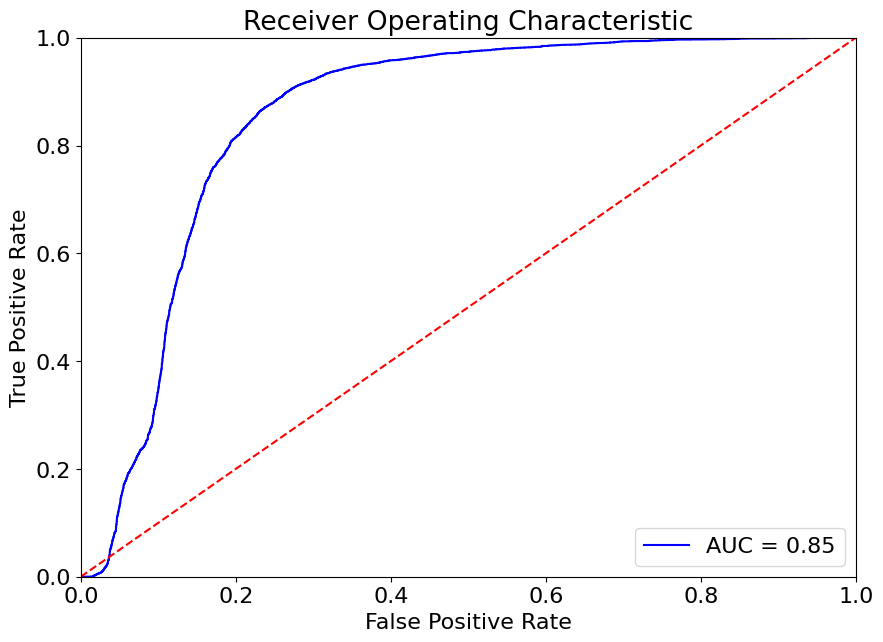

In [220]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_train,
                                         y_pred_proba_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Pada data test

In [221]:
# Menampilkan confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = y_pred_test)

array([[1539,  462],
       [  67,  331]], dtype=int64)

In [222]:
# Menampilkan score
accuracy_score(y_true = y_test,
               y_pred = y_pred_test)

0.779491454772822

In [223]:
# Menampilkan score
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.96      0.77      0.85      2001
    left (1)       0.42      0.83      0.56       398

    accuracy                           0.78      2399
   macro avg       0.69      0.80      0.70      2399
weighted avg       0.87      0.78      0.80      2399



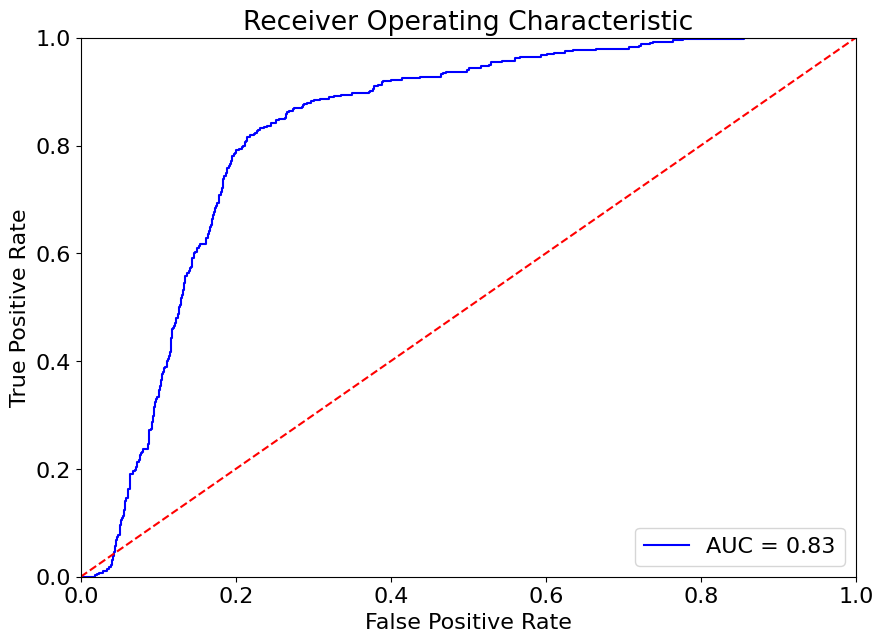

In [224]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test,
                                         y_pred_proba_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Arsitektur Lebih Kompleks**

- 1 hidden layer, dengan 3 neuron

In [225]:
# Buat arsitektur model dengan 1 perceptron
model = Sequential([
    Dense(3, input_shape = (X_train_clean.shape[1],), activation = "sigmoid"),
    Dense(1, activation = "sigmoid")
])

# Buat optimizer, menggunakan ADAM (varian gradient descent)
opt = SGD(learning_rate = 0.01)

# Compile model
model.compile(loss = "binary_crossentropy",
              optimizer = opt,
              metrics = ["accuracy"])

In [226]:
# Train model
model_hist = model.fit(X_train_clean, y_train,
                       epochs = 10,
                       verbose = 1)

Epoch 1/10
500/500 [==============================] - 2s 3ms/step - loss: 0.6908 - accuracy: 0.5586
Epoch 2/10
500/500 [==============================] - 1s 2ms/step - loss: 0.6661 - accuracy: 0.6428
Epoch 3/10
500/500 [==============================] - 1s 2ms/step - loss: 0.6413 - accuracy: 0.7007
Epoch 4/10
500/500 [==============================] - 1s 2ms/step - loss: 0.6148 - accuracy: 0.7309
Epoch 5/10
500/500 [==============================] - 1s 2ms/step - loss: 0.5874 - accuracy: 0.7614
Epoch 6/10
500/500 [==============================] - 1s 2ms/step - loss: 0.5612 - accuracy: 0.7795
Epoch 7/10
500/500 [==============================] - 1s 2ms/step - loss: 0.5375 - accuracy: 0.7982
Epoch 8/10
500/500 [==============================] - 1s 2ms/step - loss: 0.5169 - accuracy: 0.8122
Epoch 9/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4995 - accuracy: 0.8224
Epoch 10/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4850 - accuracy: 0.8279

In [227]:
# Summary Model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3)                 63        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 67 (268.00 Byte)
Trainable params: 67 (268.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


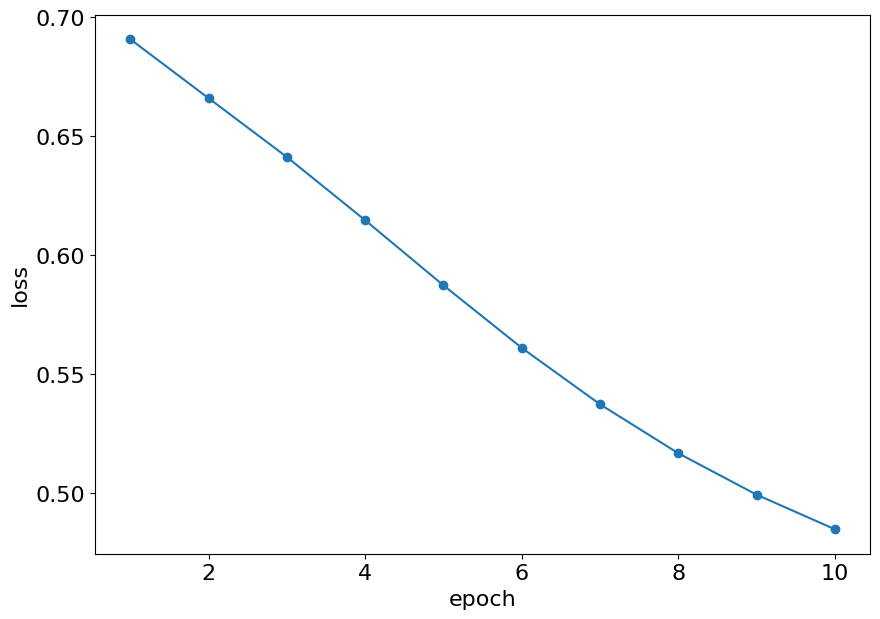

In [228]:
# Plot Error
plt.plot(1 + np.arange(10), model_hist.history["loss"], marker="o")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [229]:
# Train model - Teruskan 100 iterasi lagi
model_hist = model.fit(X_train_clean, y_train,
                       epochs = 100,
                       verbose = 1)

Epoch 1/100
500/500 [==============================] - 2s 3ms/step - loss: 0.4730 - accuracy: 0.8338
Epoch 2/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4630 - accuracy: 0.8368
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4548 - accuracy: 0.8389
Epoch 4/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4478 - accuracy: 0.8403
Epoch 5/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4418 - accuracy: 0.8423
Epoch 6/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4367 - accuracy: 0.8440
Epoch 7/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4320 - accuracy: 0.8453
Epoch 8/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4278 - accuracy: 0.8459
Epoch 9/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4240 - accuracy: 0.8467
Epoch 10/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4203 - accura

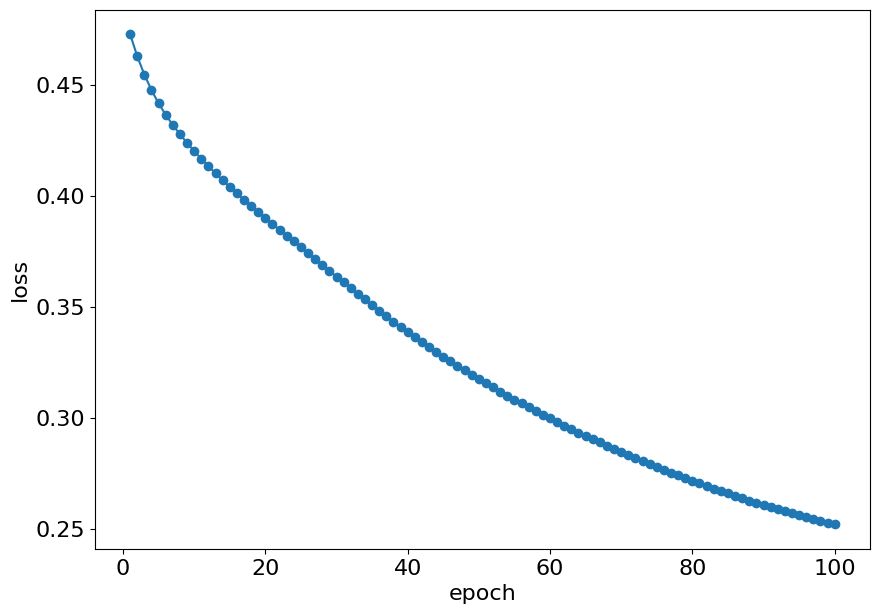

In [230]:
# Plot Error
plt.plot(1 + np.arange(100), model_hist.history["loss"], marker="o")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Pada data train

In [231]:
# Prediksi
y_pred_proba_train = model.predict(X_train_clean)
y_pred_proba_train

500/500 [==============================] - 1s 2ms/step


array([[0.5872052 ],
       [0.1713834 ],
       [0.46812072],
       ...,
       [0.884721  ],
       [0.85086405],
       [0.86916727]], dtype=float32)

In [232]:
# Buat prediksi
thresh = 0.5

y_pred_train = (y_pred_proba_train > thresh).astype("int")

Pada data test

In [233]:
# Prediksi
y_pred_proba_test = model.predict(X_test_clean)
y_pred_proba_test

75/75 [==============================] - 0s 3ms/step


array([[0.26241067],
       [0.9481254 ],
       [0.0198828 ],
       ...,
       [0.01362567],
       [0.01468191],
       [0.25185436]], dtype=float32)

In [234]:
# Buat prediksi
y_pred_test = (y_pred_proba_test > thresh).astype("int")

Cek performa

Pada data train

In [235]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_train,
                 y_pred = y_pred_train)

array([[7076,  923],
       [ 458, 7541]], dtype=int64)

In [236]:
# Tampilkan score
accuracy_score(y_true = y_train,
               y_pred = y_pred_train)

0.9136767095886986

In [237]:
# Tampilkan score
print(classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.94      0.88      0.91      7999
    left (1)       0.89      0.94      0.92      7999

    accuracy                           0.91     15998
   macro avg       0.92      0.91      0.91     15998
weighted avg       0.92      0.91      0.91     15998



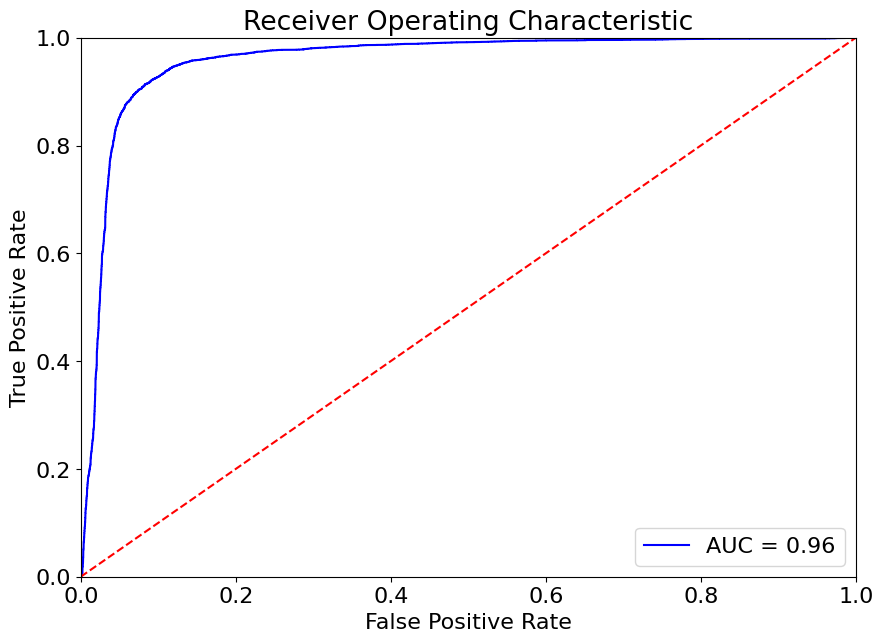

In [238]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_train,
                                         y_pred_proba_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Pada data test

In [239]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = y_pred_test)

array([[1766,  235],
       [  39,  359]], dtype=int64)

In [240]:
# Tampilkan score
accuracy_score(y_true = y_test,
               y_pred = y_pred_test)

0.885785744060025

In [241]:
# Tampilkan score
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.98      0.88      0.93      2001
    left (1)       0.60      0.90      0.72       398

    accuracy                           0.89      2399
   macro avg       0.79      0.89      0.83      2399
weighted avg       0.92      0.89      0.89      2399



- Recall bisa dinaikan hingga 88%

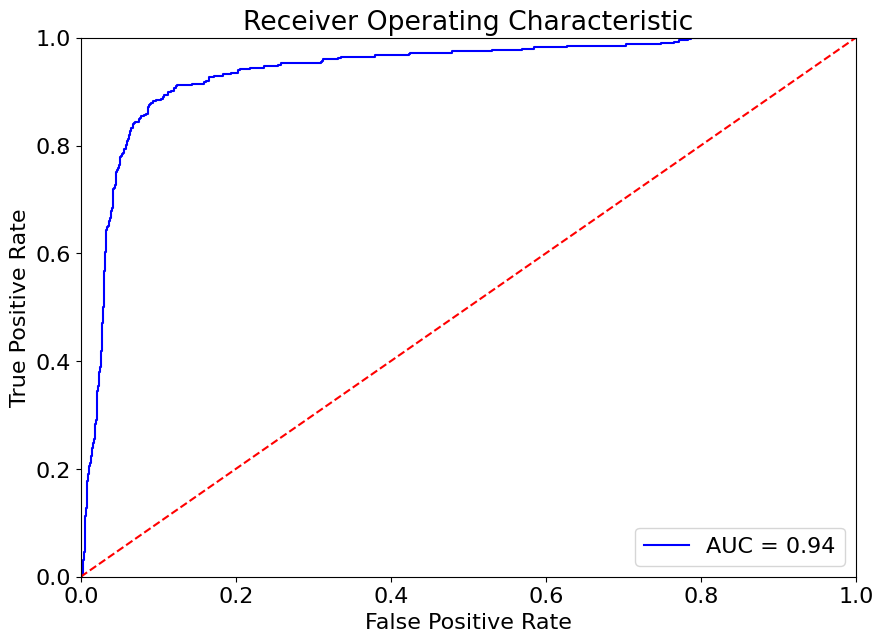

In [242]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test,
                                         y_pred_proba_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()